In [1]:
'''
Evaluate trained PredNet on KITTI sequences.
Calculates mean-squared error and plots predictions.
'''

import os
import numpy as np
from six.moves import cPickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten, UpSampling3D

from prednet import PredNet
from data_utils import SequenceGenerator
from kitti_settings import *


n_plot = 40
batch_size = 10
nt = 10

weights_file = os.path.join(WEIGHTS_DIR, 'tensorflow_weights/prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')
test_file = os.path.join(DATA_DIR, 'X_test.hkl')
test_sources = os.path.join(DATA_DIR, 'sources_test.hkl')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
input_shape = list(train_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))
predictions = test_prednet(inputs)
test_model = Model(inputs=inputs, outputs=predictions)

In [3]:
#had to run this to avoid a weird error with the kernel dying
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
#first we predict for the illusion model
import cv2
im = cv2.imread("Test_data_illusion_single_L.jpg",-1)
type(im)
b,g,r = cv2.split(im)
im2 = cv2.merge([r,g,b])
newim = np.pad(im2,((0,8),(0,0),(0,0)), 'constant',constant_values=(127))
newim = np.resize(newim,(1,10,128,160,3))
newim2 = np.transpose(newim,(0,1,4,2,3))
X_ill = test_model.predict(newim2, batch_size)
X_ill = np.transpose(X_ill, (0, 1, 3, 4, 2))

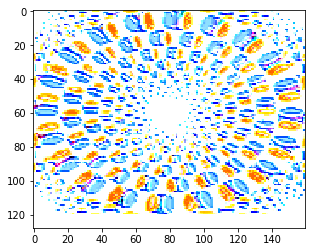

In [5]:
plt.imshow(X_ill[0,9])

In [6]:
#testing the detected "movement" via mean square error
movement = []
for i in range(10):
    movement.append(np.mean(newim[0,0] - X_ill[0,i])**2)
movement

[18514.30775076989,
 18332.50135235139,
 18338.323810830712,
 18339.17514907662,
 18339.323928662576,
 18339.34872531891,
 18339.356990874745,
 18339.36112365336,
 18339.36112365336,
 18339.365256432444]

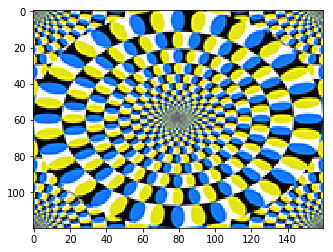

In [7]:
plt.imshow(im2)

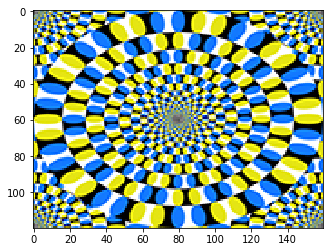

In [8]:
#now the non-illusion image for compariseon
imm = cv2.imread("Test_data_non_illusion_single.jpg",-1)
type(im)
b,g,r = cv2.split(imm)
imm2 = cv2.merge([r,g,b])
plt.imshow(imm2)
newimm = np.pad(imm2,((0,8),(0,0),(0,0)), 'constant',constant_values=(127))
newimm = np.resize(newimm,(1,10,128,160,3))
newimm2 = np.transpose(newimm,(0,1,4,2,3))
X_ill2 = test_model.predict(newimm2, batch_size)
X_ill2 = np.transpose(X_ill2, (0, 1, 3, 4, 2))

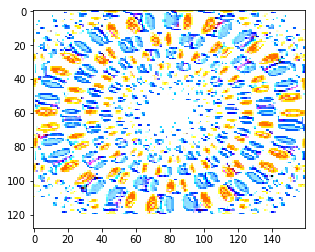

In [9]:
plt.imshow(X_ill2[0,9])

In [10]:
movement2 = []
for i in range(10):
    movement2.append(np.mean(newimm[0,0] - X_ill2[0,i])**2)
movement2

[18483.833056245,
 18301.75560266734,
 18307.569047818193,
 18308.386637579883,
 18308.522904315032,
 18308.53529222519,
 18308.53529222519,
 18308.53116292134,
 18308.527033617953,
 18308.522904315032]